In [3]:
import pandas as pd
import numpy as np
from env import get_db_url
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:,.3f}'.format

In [1]:
from importlib import reload

In [2]:
import wrangle_mall as wm

In [71]:
# define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [85]:
seed = 42

In [87]:
reload(wm)

<module 'wrangle_mall' from '/Users/nadina/codeup-data-science/clustering-exercises/wrangle_mall.py'>

In [88]:
train, validate, test = wm.get_mall_customers()

In [89]:
train.shape[0], validate.shape[0], test.shape[0]

(112, 48, 40)

### Exploration

#### What is a distribution of each var

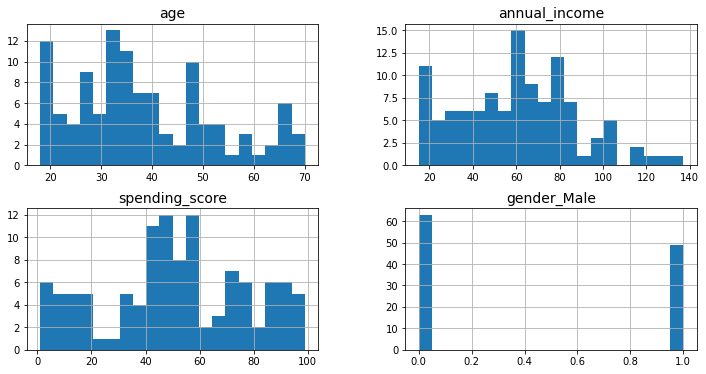

In [90]:
train.hist(bins=20, figsize=(12, 6));

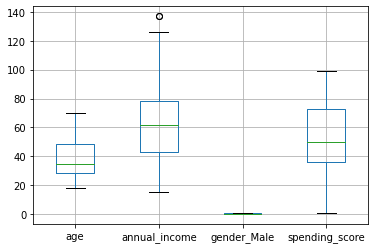

In [73]:
train.loc[:, 'age':'spending_score'].boxplot();

#### Does ```spending_score``` differ across gender?

In [76]:
train.head(1)

,age,annual_income,gender_Male,spending_score
43,31,39,0,61


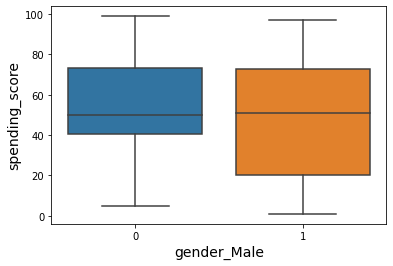

In [91]:
sns.boxplot(data=train, x='gender_Male', y='spending_score');

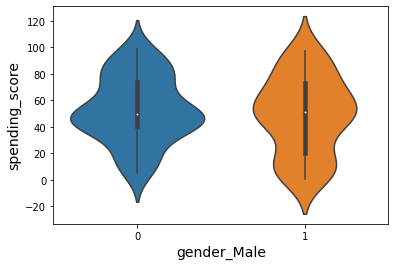

In [92]:
sns.violinplot(data=train, x='gender_Male', y='spending_score', );

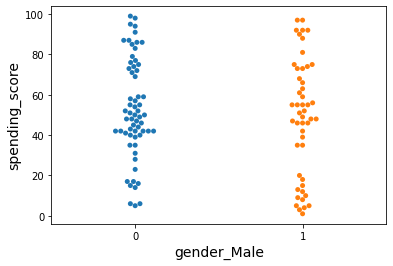

In [93]:
sns.swarmplot(data=train, x='gender_Male', y='spending_score', );

#### Is there a relationship between ```spending_score``` and ```annual_income```

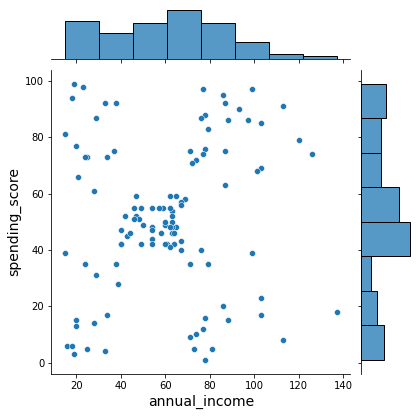

In [95]:
sns.jointplot(data=train, x='annual_income', y='spending_score');

#### Is there a relationship between ```spending_score``` and ```age```

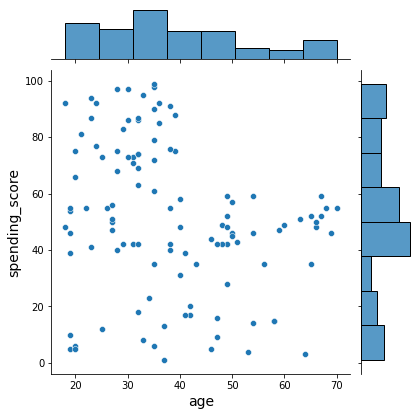

In [101]:
sns.jointplot(data=train, x='age', y='spending_score');

In [102]:
train['age_bin'] = pd.cut(train.age, [0, 40, 80])

In [103]:
train.head(1)

,age,annual_income,spending_score,gender_Male,age_bin
130,47,71,9,1,"(40, 80]"


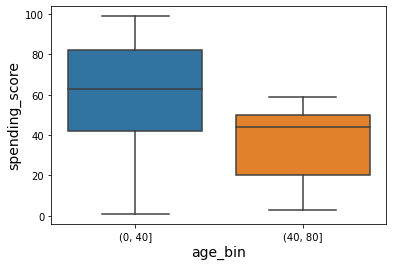

In [104]:
sns.boxplot(data=train, x='age_bin', y='spending_score');

In [105]:
import scipy.stats as stats

In [106]:
stats.levene(
    train[train.age <= 40].spending_score,
    train[train.age > 40].spending_score
)

LeveneResult(statistic=11.809551017293076, pvalue=0.0008325687159373646)

In [107]:
stats.ttest_ind(
    train[train.age <= 40].spending_score,
    train[train.age > 40].spending_score,
    equal_var=False
)

Ttest_indResult(statistic=5.011777953183408, pvalue=2.087595446622472e-06)

#### If we control for age, does ```spending_score``` differ across ```annual_income```?

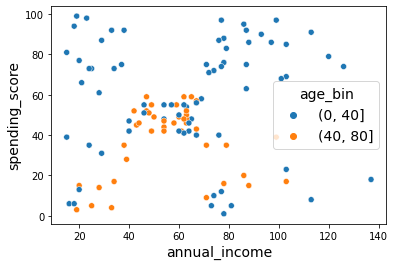

In [109]:
sns.scatterplot(data=train, x='annual_income', y='spending_score', hue='age_bin');

#### If we control for ```annual_income```, does ```spending_score``` differ across ```age```?

In [121]:
#train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 100, np.inf])
train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

In [120]:
train.annual_income.max()

137

In [122]:
train.income_bin.value_counts()

(40, 70]     41
(70, 140]    40
(0, 40]      31
Name: income_bin, dtype: int64

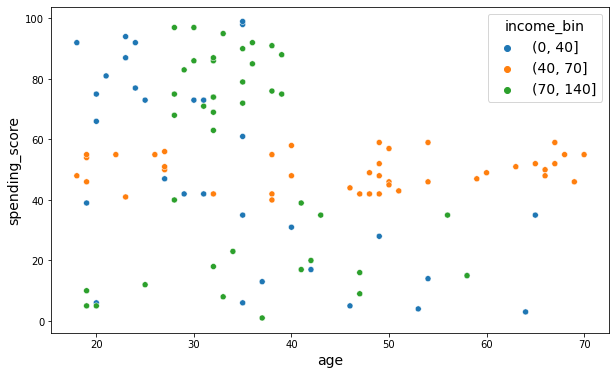

In [123]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='age',y='spending_score', hue='income_bin');

#### Pairplots

In [129]:
train.head(1)

,age,annual_income,spending_score,gender_Male,age_bin,income_bin
130,47,71,9,1,"(40, 80]","(70, 140]"


In [130]:
train.columns.tolist()

['age',
 'annual_income',
 'spending_score',
 'gender_Male',
 'age_bin',
 'income_bin']

In [131]:
train = train[['age',
 'annual_income',
 'spending_score',
 'age_bin',
 'income_bin',
 'gender_Male']]

In [134]:
train.iloc[:, :-1].head(1)

,age,annual_income,spending_score,age_bin,income_bin
130,47,71,9,"(40, 80]","(70, 140]"


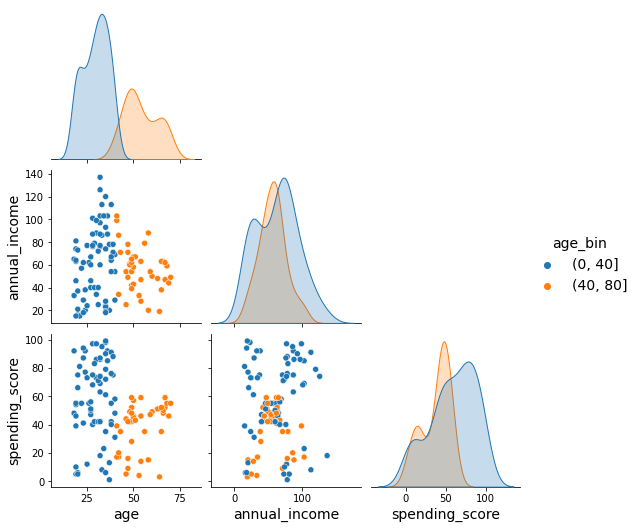

In [136]:
sns.pairplot(data=train.iloc[:, :-1], hue='age_bin', corner=True);

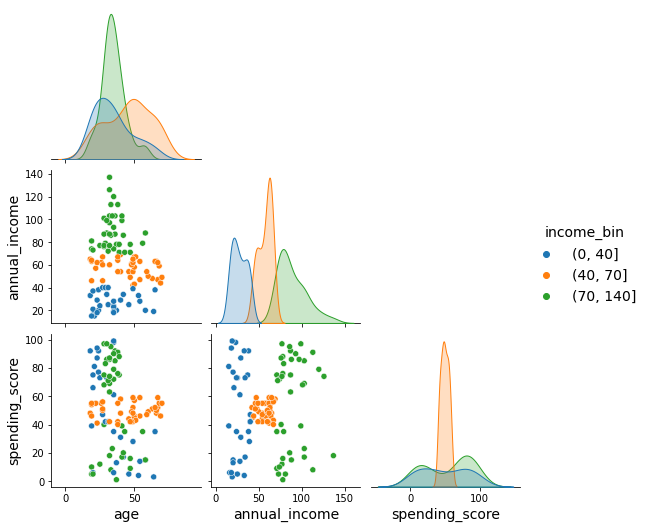

In [135]:
sns.pairplot(data=train.iloc[:, :-1], hue='income_bin', corner=True);

#####  Quick K-Means visualization 

In [41]:
train = train[['age', 'annual_income', 'gender_Male', 'spending_score' ]]
X = train.iloc[:, :-1]

In [42]:
from sklearn.cluster import KMeans
wcss = [] #Within-Cluster Sum of Square
# run the loop with clusters from 1 to 10 to find the best n_clusters number
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=seed)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

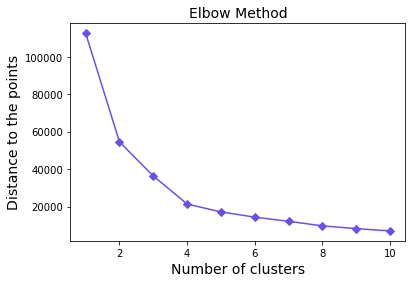

In [74]:
# plot wcss to find the 'elbow'
plt.plot(range(1, 11), wcss, color='#6d4ee9', marker='D')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distance to the points')
plt.show()

In [61]:
k = 4 # is the best number for kmeans

In [62]:
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
y_means = kmeans.fit_predict(X)

In [63]:
y_means

array([2, 0, 0, 0, 3, 2, 3, 3, 2, 0, 2, 2, 0, 0, 3, 3, 0, 3, 3, 1, 2, 1,
       0, 3, 3, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 2, 3, 0, 3, 1, 0,
       3, 2, 0, 3, 2, 2, 0, 1, 0, 1, 2, 1, 0, 1, 3, 3, 3, 2, 0, 0, 1, 2,
       0, 1, 1, 3, 2, 3, 2, 2, 1, 0, 3, 0, 3, 0, 0, 0, 1, 1, 3, 3, 0, 2,
       1, 0, 3, 0, 3, 3, 0, 1, 2, 1, 0, 3, 2, 2, 0, 3, 0, 2, 0, 3, 3, 2,
       3, 0], dtype=int32)

In [59]:
X['group'] = y_means

In [50]:
X.head(1)

,age,annual_income,gender_Male,group
43,31,39,0,3


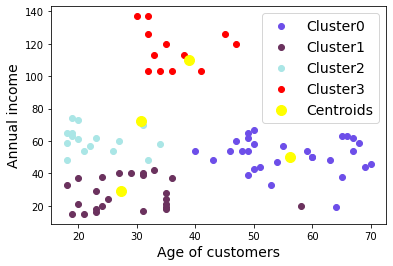

In [75]:
colors = ['#6d4ee9', '#6b325e', '#aae6e6', 'red', '#c7e7c9']
for i in range(4):
    plt.scatter(X[X.group==i].age, X[X.group==i].annual_income, color=colors[i], label='Cluster'+str(i))
    plt.legend()
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, color='yellow', label = 'Centroids')
plt.xlabel('Age of customers')
plt.ylabel('Annual income')
plt.legend();